In [2]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

In [1]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# create new figure, axes instances.
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
# draw great circle route between NY and London
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title('Great Circle from New York to London')
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [ ]:
def main():
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([160, 170, -25, -19])

    # Put a background image on for nice sea rendering.


    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    reefs = cfeature.NaturalEarthFeature(
        category='physical',
        name='reefs',
        scale='10m')
    
    coasts = cfeature.NaturalEarthFeature(
        category='physical',
        name='coastline',
        scale='10m',
        edgecolor='black',
        facecolor='none')
    
    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='10m',
        edgecolor='face',
        facecolor=cfeature.COLORS['land'])
    
    rivers = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers',
        scale='10m',
        edgecolor='face',
        facecolor=cfeature.COLORS['water'])

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax.add_feature(land)
    ax.add_feature(coasts)
    ax.add_feature(reefs)
    ax.add_feature(rivers)

    # Add a text annotation for the license information to the
    # the bottom right corner.
    text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=4, prop={'size': 12}, frameon=True)
    ax.add_artist(text)
    plt.show()


if __name__ == '__main__':
    main()

In [ ]:
dir(ax)

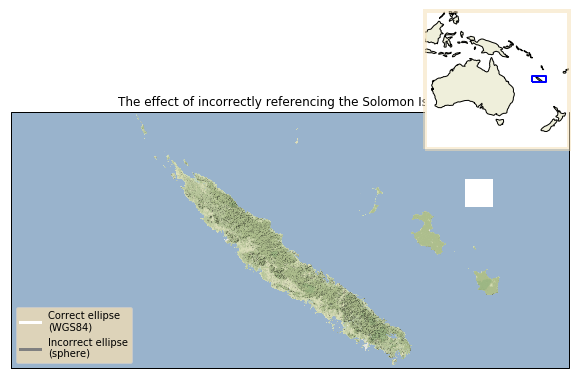

In [5]:
"""
The effect of badly referencing an ellipse
------------------------------------------

This example demonstrates the effect of referencing your data to an incorrect
ellipse.

First we define two coordinate systems - one using the World Geodetic System
established in 1984 and the other using a spherical globe. Next we extract
data from the Natural Earth land dataset and convert the Geodetic
coordinates (referenced in WGS84) into the respective coordinate systems
that we have defined. Finally, we plot these datasets onto a map assuming
that they are both referenced to the WGS84 ellipse and compare how the
coastlines are shifted as a result of referencing the incorrect ellipse.

"""
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.io.img_tiles import StamenTerrain
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D as Line
from matplotlib.patheffects import Stroke
import numpy as np
import shapely.geometry as sgeom
from shapely.ops import transform as geom_transform
plt.figure(figsize=(10,10))

def transform_fn_factory(target_crs, source_crs):
    """
    Return a function which can be used by ``shapely.op.transform``
    to transform the coordinate points of a geometry.

    The function explicitly *does not* do any interpolation or clever
    transformation of the coordinate points, so there is no guarantee
    that the resulting geometry would make any sense.

    """
    def transform_fn(x, y, z=None):
        new_coords = target_crs.transform_points(source_crs,
                                                 np.asanyarray(x),
                                                 np.asanyarray(y))
        return new_coords[:, 0], new_coords[:, 1], new_coords[:, 2]

    return transform_fn


def main():
    # Define the two coordinate systems with different ellipses.
    wgs84 = ccrs.PlateCarree(globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))
    sphere = ccrs.PlateCarree(globe=ccrs.Globe(datum='WGS84',
                                               ellipse='sphere'))

    # Define the coordinate system of the data we have from Natural Earth and
    # acquire the 1:10m physical coastline shapefile.
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
    dataset = cartopy.feature.NaturalEarthFeature(category='physical',
                                                  name='coastline',
                                                  scale='10m')

    # Create a Stamen map tiler instance, and use its CRS for the GeoAxes.
    tiler = StamenTerrain()
    ax = plt.axes(projection=tiler.crs)
    plt.title('The effect of incorrectly referencing the Solomon Islands')

    # Pick the area of interest. In our case, roughly the Solomon Islands, and
    # get hold of the coastlines for that area.
    extent = (169, 162, -22.5, -19.5)
    ax.set_extent(extent, geodetic)
    geoms = list(dataset.intersecting_geometries(extent))

    # Add the Stamen aerial imagery at zoom level 7.
    ax.add_image(tiler, 10)

    # Transform the geodetic coordinates of the coastlines into the two
    # projections of differing ellipses.
    wgs84_geoms = [geom_transform(transform_fn_factory(wgs84, geodetic),
                                  geom) for geom in geoms]
    sphere_geoms = [geom_transform(transform_fn_factory(sphere, geodetic),
                                   geom) for geom in geoms]

    # Using these differently referenced geometries, assume that they are
    # both referenced to WGS84.
    ax.add_geometries(wgs84_geoms, wgs84, edgecolor='white', color='none')
    ax.add_geometries(sphere_geoms, wgs84, edgecolor='gray', color='none')

    # Create a legend for the coastlines.
    legend_artists = [Line([0], [0], color=color, linewidth=3)
                      for color in ('white', 'gray')]
    legend_texts = ['Correct ellipse\n(WGS84)', 'Incorrect ellipse\n(sphere)']
    legend = plt.legend(legend_artists, legend_texts, fancybox=True,
                        loc='lower left', framealpha=0.75)
    legend.legendPatch.set_facecolor('wheat')

    # Create an inset GeoAxes showing the location of the Solomon Islands.
    sub_ax = plt.axes([0.7, 0.625, 0.2, 0.2], projection=ccrs.PlateCarree())
    sub_ax.set_extent([110, 180, -50, 10], geodetic)

    # Make a nice border around the inset axes.
    effect = Stroke(linewidth=4, foreground='wheat', alpha=0.5)
    sub_ax.outline_patch.set_path_effects([effect])

    # Add the land, coastlines and the extent of the Solomon Islands.
    sub_ax.add_feature(cartopy.feature.LAND)
    sub_ax.coastlines()
    extent_box = sgeom.box(extent[0], extent[2], extent[1], extent[3])
    sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color='none',
                          edgecolor='blue', linewidth=2)

    plt.show()


if __name__ == '__main__':
    main()

In [7]:
help(plt.axes)

Help on function axes in module matplotlib.pyplot:

axes(arg=None, **kwargs)
    Add an axes to the current figure and make it the current axes.
    
    Parameters
    ----------
    arg : None or 4-tuple or Axes
        The exact behavior of this function depends on the type:
    
        - *None*: A new full window axes is added using
          ``subplot(111, **kwargs)``
        - 4-tuple of floats *rect* = ``[left, bottom, width, height]``.
          A new axes is added with dimensions *rect* in normalized
          (0, 1) units using `~.Figure.add_axes` on the current figure.
        - `.Axes`: This is equivalent to `.pyplot.sca`. It sets the current
          axes to *arg*. Note: This implicitly changes the current figure to
          the parent of *arg*.
    
          .. note:: The use of an Axes as an argument is deprecated and will be
                    removed in v3.0. Please use `.pyplot.sca` instead.
    
    Other Parameters
    ----------------
    **kwargs :
        Fo

In [ ]:
%matplotlib inline

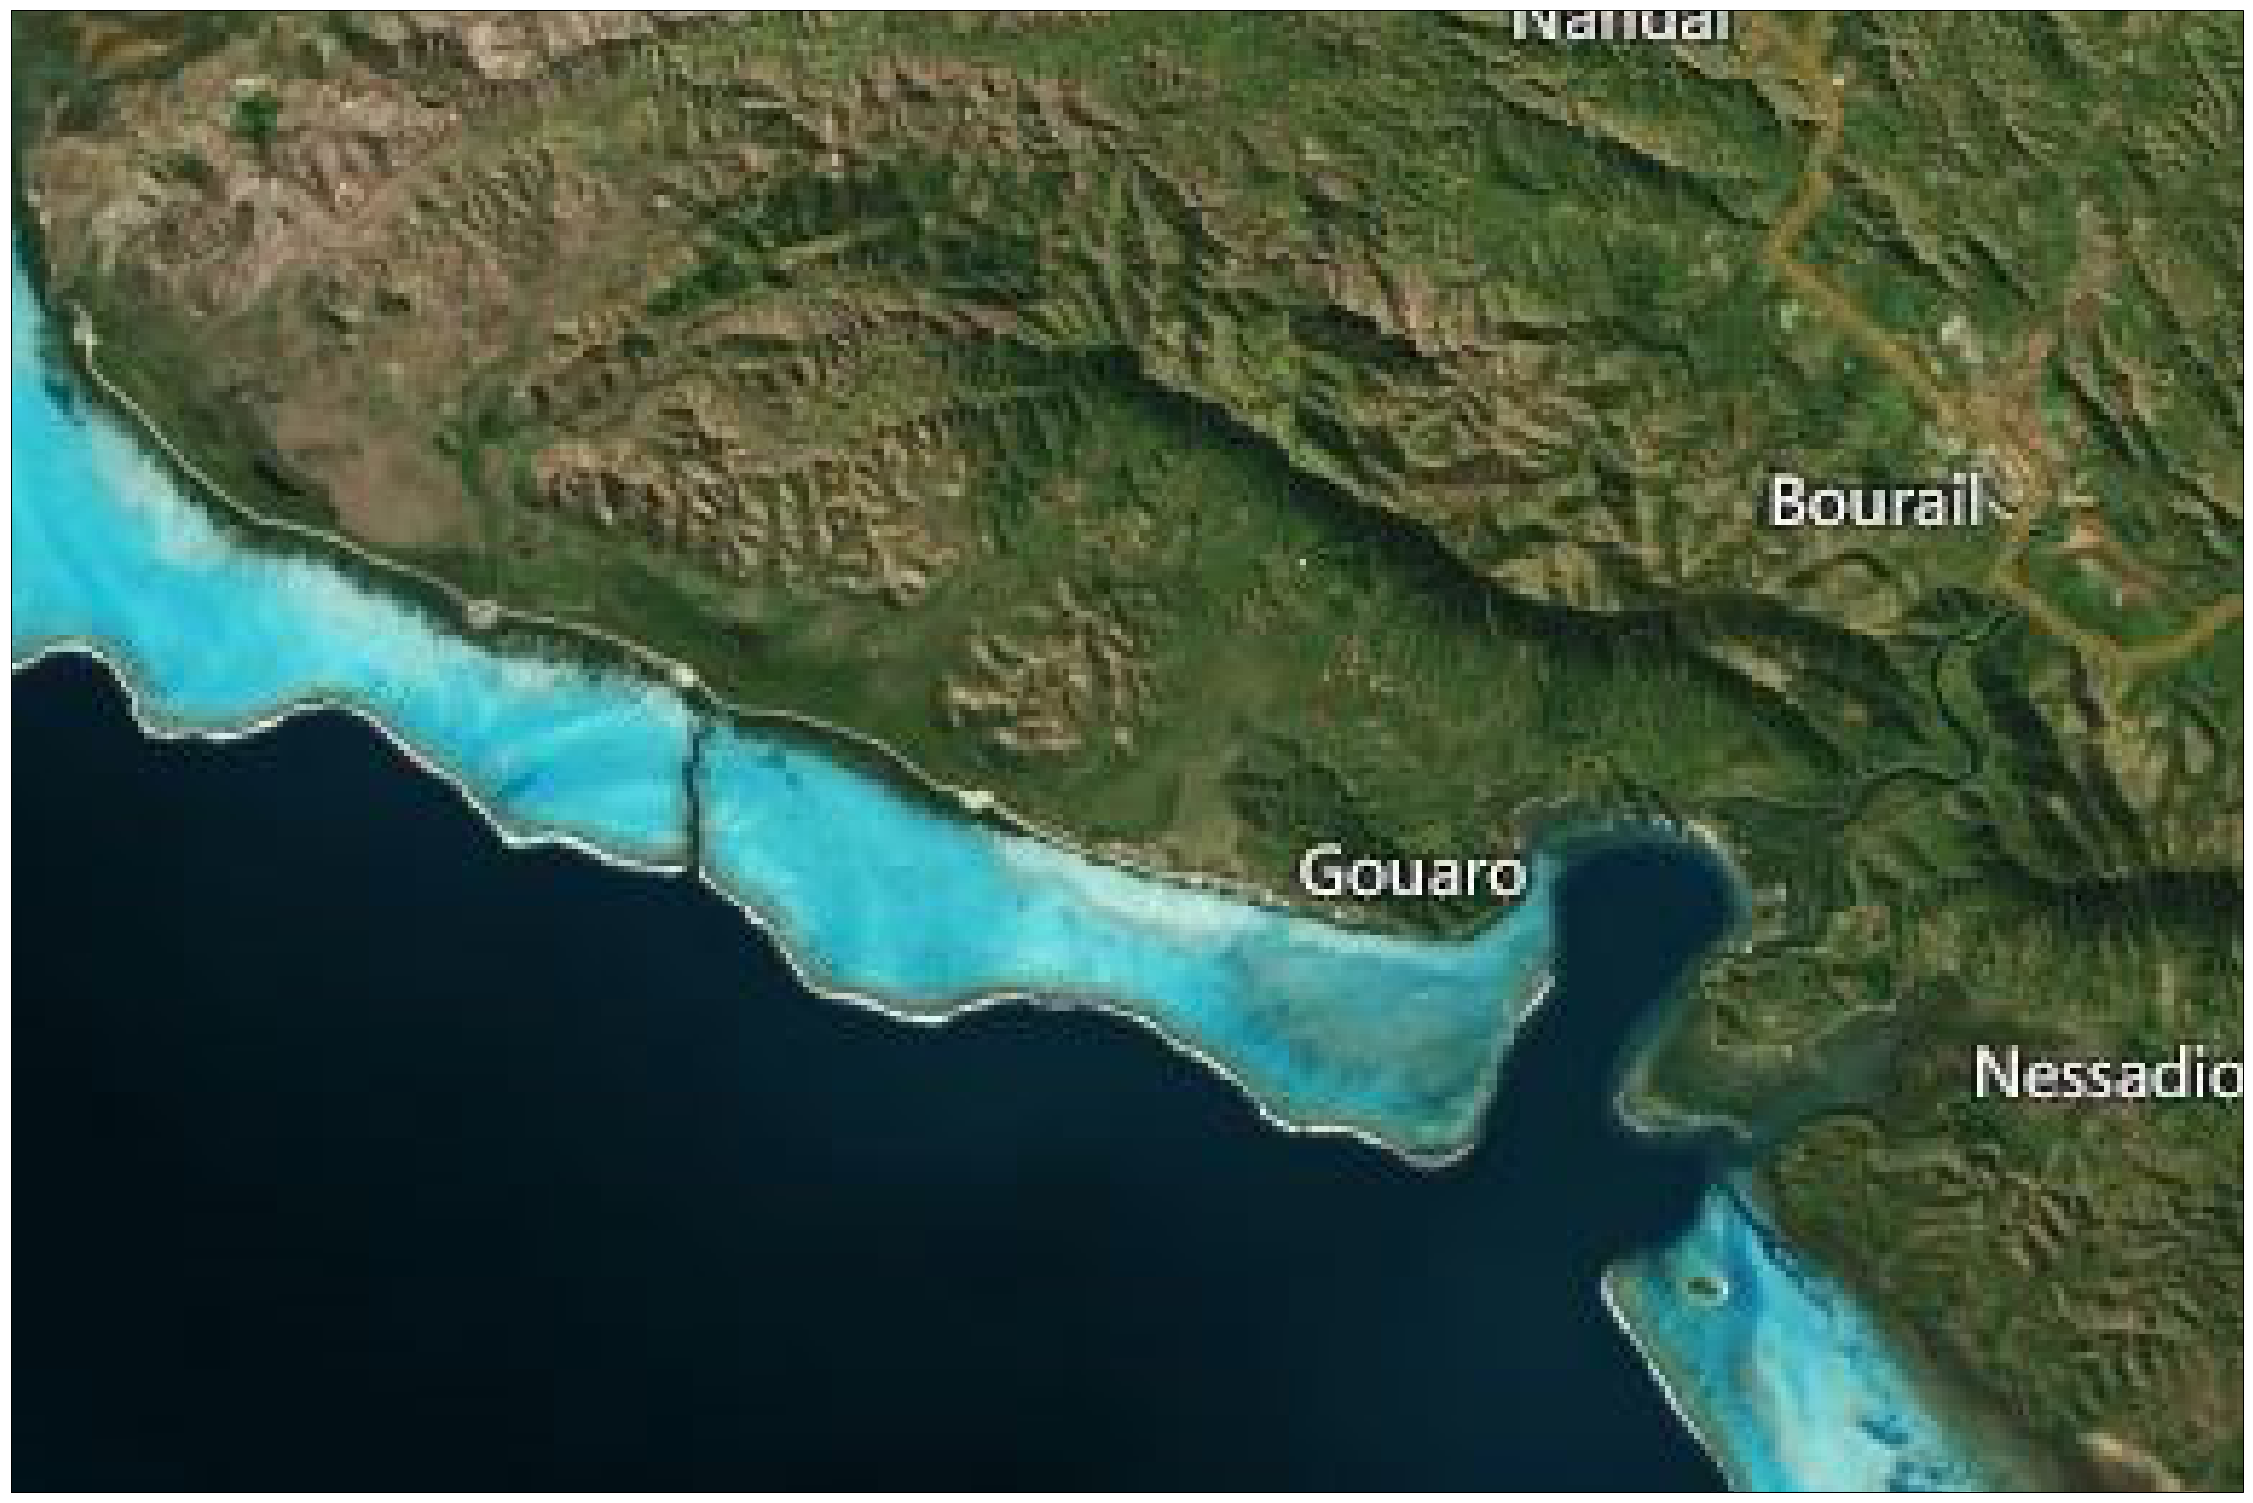

In [6]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

plt.figure(figsize=(40,40))
def main():
    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.QuadtreeTiles()

    # Create a GeoAxes in the tile's projection.
    ax = plt.axes(projection=stamen_terrain.crs)

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([165.5233, 165.2578, -21.6810, -21.5171])
    #ax.set_extent([165.38758, 165.38733, -21.6184900, -21.6181800])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 11)

    # Add a marker for the Eyjafjallajökull volcano.
    #plt.plot(-19.613333, 63.62, marker='o', color='red', markersize=12,
    #        alpha=0.7, transform=ccrs.Geodetic())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=-25)

    # Add text 25 pixels to the left of the volcano.
    #plt.text(-19.613333, 63.62, u'Eyjafjallajökull',
    #        verticalalignment='center', horizontalalignment='right',
    #        transform=text_transform,
    #        bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
    plt.show()


if __name__ == '__main__':
    main()

In [8]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

fig = plt.figure()

def main():
    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.StamenTerrain()

    # Create a GeoAxes in the tile's projection.
    ax = plt.axes(projection=stamen_terrain.crs)

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([165.5533, 165.2378, -21.7010, -21.4971])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 11)

    # Add a marker for the Eyjafjallajökull volcano.
    plt.plot(-21.609963, 165.389559, marker='o', color='red', markersize=12,
             alpha=1, transform=ccrs.Geodetic())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=-25)

    # Add text 25 pixels to the left of the volcano.
    plt.text(-21.609963, 165.389559, u'Poe',
             verticalalignment='center', horizontalalignment='right',
             transform=text_transform,
             bbox=dict(facecolor='sandybrown', alpha=0, boxstyle='round'))
    plt.show()


if __name__ == '__main__':
    main()

ValueError: Image size of 164211x22073 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>